In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
torch.cuda.is_available()

True

In [2]:
# Transforms images to a PyTorch Tensor
tensor_transform = transforms.ToTensor()
 
# Download the MNIST Dataset
dataset = datasets.MNIST(root = "./data",
                         train = True,
                         download = True,
                         transform = tensor_transform)
 
# DataLoader is used to load the dataset 
# for training
loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = 32,
                                     shuffle = True)

In [3]:
# Creating a PyTorch class
# 28*28 ==> 9 ==> 28*28
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
epochs = 30
batch_size = 64
lr = 0.001
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
print(device)

cuda


In [5]:
model_ae = AutoEncoder().to(device)
optimizer = torch.optim.Adam(model_ae.parameters(), lr=lr)
loss_function = torch.nn.MSELoss().to(device)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10,40], gamma=0.5)

In [6]:
# Train
log_loss=[]
for epoch in range(epochs):
    total_loss = 0
    for data, _ in loader:
        inputs = data.view(-1, 784).to(device) 
        model_ae.zero_grad()
        # Forward
        reconstruct = model_ae(inputs)
        loss = loss_function(reconstruct, inputs)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        log_loss.append(loss.data.cpu())
    total_loss /= len(loader.dataset)
    scheduler.step()
    
    if epoch % 5 ==0:
        print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())
print('[{}/{}] Loss:'.format(epoch+1, epochs), total_loss.item())

[1/30] Loss: 0.0016316358232870698
[6/30] Loss: 0.0007362639298662543
[11/30] Loss: 0.0006402187282219529
[16/30] Loss: 0.0006177461473271251
[21/30] Loss: 0.0006022878806106746
[26/30] Loss: 0.0005770375137217343
[30/30] Loss: 0.0005513778305612504


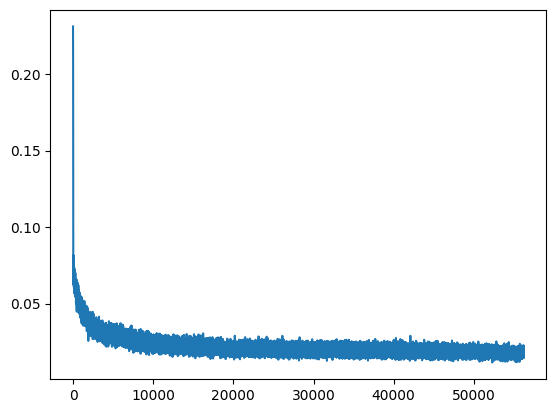

In [7]:
plt.plot(log_loss)